In [1]:
import json
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report

with open('arxiv_data.json', 'r') as f:
    data = json.load(f)


# 構建 DataFrame
df = pd.DataFrame({
    'title': data['titles'],
    'abstract': data['summaries'],
    'labels': data['terms']
})

# 查看 DataFrame 結構
print(df.head())
# 把 85% 的數據分割為訓練集和 15% 的數據分割為測試集
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)

# 把訓練集再分割出 15% 作為驗證集 (即 70% 訓練集, 15% 驗證集)
train_df, val_df = train_test_split(train_df, test_size=0.1765, random_state=42)  # 0.1765 確保驗證集約佔 15% 原始數據

# 查看各集的大小
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Testing set size:", len(test_df))

# 解析和視覺化標籤分佈
# 展開標籤並統計頻次
all_labels = [label for labels in df['labels'] for label in labels]
label_counts = pd.Series(all_labels).value_counts()


# 假設 df 是您處理過的 DataFrame
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 去除標點符號和停用詞
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # 去除非字母字符
    text = text.lower()  # 全部轉小寫
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['abstract'] = df['abstract'].apply(preprocess_text)

# 將多標籤轉為二值矩陣
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels'])

# 分割訓練集、驗證集、測試集
train_texts, test_texts, y_train, y_test = train_test_split(df['abstract'], y, test_size=0.15, random_state=42)
train_texts, val_texts, y_train, y_val = train_test_split(train_texts, y_train, test_size=0.1765, random_state=42)
from sklearn.feature_extraction.text import TfidfVectorizer

# 使用 TF-IDF 表示文本特徵
tfidf = TfidfVectorizer(max_features=500)  # 限制特徵數量以提高速度
X_train = tfidf.fit_transform(train_texts).toarray()
X_val = tfidf.transform(val_texts).toarray()
X_test = tfidf.transform(test_texts).toarray()


# 定義不含 SVM 的模型列表
models = {
    # 'Naive Bayes': MultinomialNB(),
    # 'Logistic Regression': LogisticRegression(max_iter=1000),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100),
    # 'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
    # 'Ridge Classifier': RidgeClassifier()
}

# 儲存訓練和推理時間的字典
train_times = {}
inference_times = {}
val_scores = {}
reports = {}

# 訓練每個模型並評估驗證集的表現
total_models = len(models)
for idx, (name, model) in enumerate(models.items(), start=1):
    multi_target_model = MultiOutputClassifier(model, n_jobs=-1)
    
    # 訓練時間測量
    start_time = time.time()
    multi_target_model.fit(X_train, y_train)
    train_times[name] = time.time() - start_time
    
    # 推理時間測量
    start_time = time.time()
    y_val_pred = multi_target_model.predict(X_val)
    inference_times[name] = time.time() - start_time
    
    # 計算 F1 分數作為驗證指標
    score = f1_score(y_val, y_val_pred, average='micro')  # 使用微平均
    val_scores[name] = score
    print(f"{name} Validation F1 Score: {score:.4f}")
    
    # 生成分類報告（驗證集）
    reports[name] = classification_report(y_val, y_val_pred, zero_division=0)
    print(f"{name} Validation Classification Report:\n{reports[name]}")
    
    # 顯示進度百分比
    progress = (idx / total_models) * 100
    print(f"Progress: {progress:.2f}% complete\n")

# 選擇最佳模型進行測試報告
best_model_name = max(val_scores, key=val_scores.get)
best_model = MultiOutputClassifier(models[best_model_name], n_jobs=-1)
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

# 生成測試集的分類報告
test_report = classification_report(y_test, y_test_pred, zero_division=0)
print(f"\nTest Classification Report ({best_model_name}):\n{test_report}")

# 顯示各分類器的訓練和推理時間
print("\nTraining and Inference Times:")
for name in models.keys():
    print(f"{name} - Training time: {train_times[name]:.4f} seconds, Inference time: {inference_times[name]:.4f} seconds")

# 假設 best_model 是您選擇的最佳模型，且已經完成訓練
# 使用最佳模型進行預測
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# 生成分類報告
val_report = classification_report(y_val, y_val_pred, zero_division=0)
test_report = classification_report(y_test, y_test_pred, zero_division=0)

# 將報告寫入 results.txt
output_path = "SGB_Results.txt"
with open(output_path, "w") as f:
    f.write("Validation Classification Report:\n")
    f.write(val_report)
    f.write("\n\nTest Classification Report:\n")
    f.write(test_report)

print(f"Results saved to {output_path}")


                                               title  \
0  Survey on Semantic Stereo Matching / Semantic ...   
1  FUTURE-AI: Guiding Principles and Consensus Re...   
2  Enforcing Mutual Consistency of Hard Regions f...   
3  Parameter Decoupling Strategy for Semi-supervi...   
4  Background-Foreground Segmentation for Interio...   

                                            abstract                 labels  
0  Stereo matching is one of the widely used tech...         [cs.CV, cs.LG]  
1  The recent advancements in artificial intellig...  [cs.CV, cs.AI, cs.LG]  
2  In this paper, we proposed a novel mutual cons...         [cs.CV, cs.AI]  
3  Consistency training has proven to be an advan...                [cs.CV]  
4  To ensure safety in automated driving, the cor...         [cs.CV, cs.LG]  
Training set size: 36239
Validation set size: 7768
Testing set size: 7767


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Hist Gradient Boosting Validation F1 Score: 0.7322
Hist Gradient Boosting Validation Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.25      0.07         4
           1       0.00      0.00      0.00        11
           2       0.14      0.30      0.19        10
           3       0.00      0.00      0.00         6
           4       0.69      0.20      0.31      1150
           5       0.05      0.40      0.09         5
           6       0.03      0.25      0.06         4
           7       0.00      0.00      0.00         9
           8       1.00      0.53      0.69        19
           9       0.89      0.53      0.66       238
          10       0.58      0.30      0.40       103
          11       0.94      0.93      0.93      4526
          12       0.67      0.20      0.31        30
          13       0.62      0.22      0.32        23
          14       0.75      0.24      0.37        49
          15       0.00    

In [2]:
import optuna
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

# 先前的代碼準備
# 這裡假設您已經完成了數據加載和預處理等操作

# 定義目標函數
def objective(trial):
    # 定義超參數搜索空間
    max_iter = trial.suggest_int("max_iter", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 10, 100)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    
    # 初始化模型
    model = HistGradientBoostingClassifier(
        max_iter=max_iter,
        learning_rate=learning_rate,
        max_leaf_nodes=max_leaf_nodes,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # 使用多標籤分類器封裝模型
    multi_target_model = MultiOutputClassifier(model, n_jobs=-1)
    
    # 訓練模型
    multi_target_model.fit(X_train, y_train)
    
    # 驗證集評估
    y_val_pred = multi_target_model.predict(X_val)
    score = f1_score(y_val, y_val_pred, average='micro')  # 使用微平均計算F1分數
    
    return score

# 創建Optuna的研究對象，並運行優化
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 顯示最佳超參數
print("Best hyperparameters:", study.best_params)
print("Best micro F1 score:", study.best_value)

# 使用最佳超參數訓練和測試模型
best_params = study.best_params
best_model = HistGradientBoostingClassifier(
    max_iter=best_params["max_iter"],
    learning_rate=best_params["learning_rate"],
    max_leaf_nodes=best_params["max_leaf_nodes"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42
)
best_multi_target_model = MultiOutputClassifier(best_model, n_jobs=-1)
best_multi_target_model.fit(X_train, y_train)

# 驗證集和測試集的分類報告
y_val_pred = best_multi_target_model.predict(X_val)
y_test_pred = best_multi_target_model.predict(X_test)

val_report = classification_report(y_val, y_val_pred, zero_division=0)
test_report = classification_report(y_test, y_test_pred, zero_division=0)

# 儲存結果
output_path = "Optimized_HistGradientBoosting_Results.txt"
with open(output_path, "w") as f:
    f.write("Validation Classification Report:\n")
    f.write(val_report)
    f.write("\n\nTest Classification Report:\n")
    f.write(test_report)

print(f"Results saved to {output_path}")


C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-18 18:14:46,643] A new study created in memory with name: no-name-645866b3-047c-41f3-a2e8-c71f96bf3818
[I 2024-11-18 18:17:43,828] Trial 0 finished with value: 0.7630790190735695 and parameters: {'max_iter': 293, 'learning_rate': 0.08090556204719598, 'max_leaf_nodes': 50, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.7630790190735695.
[I 2024-11-18 18:21:54,436] Trial 1 finished with value: 0.7583637744583891 and parameters: {'max_iter': 258, 'learning_rate': 0.02286218428721065, 'max_leaf_nodes': 54, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7630790190735695.
[I 2024-11-18 18:23:59,162] Trial 2 finished with value: 0.7371779311301454 and parameters: {'max_iter': 89, 'learning_rate': 0.0572376271078

Best hyperparameters: {'max_iter': 291, 'learning_rate': 0.02352665012933259, 'max_leaf_nodes': 96, 'min_samples_leaf': 9}
Best micro F1 score: 0.7821721825809459
Results saved to Optimized_HistGradientBoosting_Results.txt


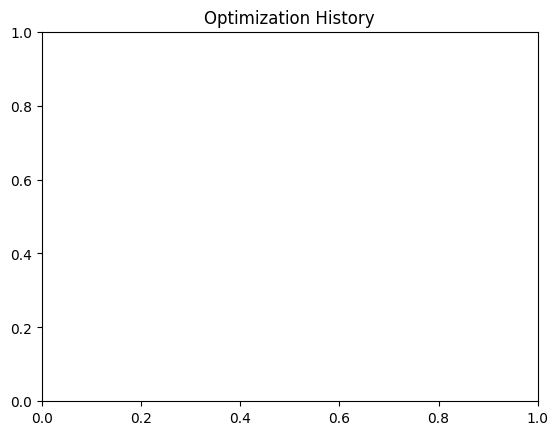

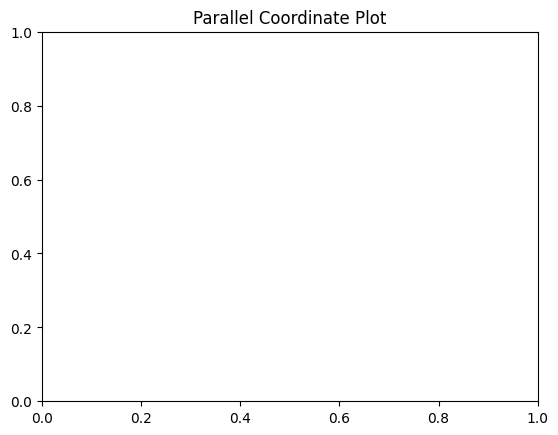

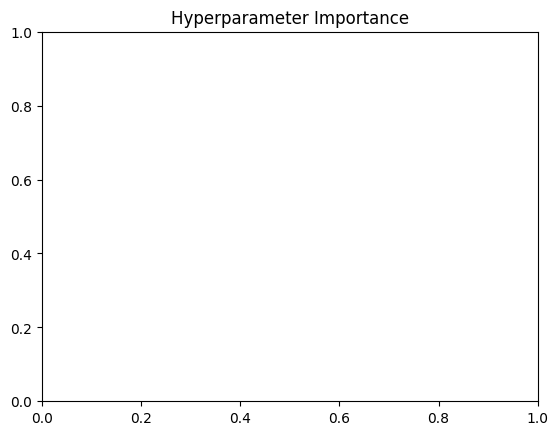

In [3]:
# 生成並保存可視化圖表
# 1. 優化歷史 (Optimization History)
optuna.visualization.plot_optimization_history(study)
plt.title("Optimization History")
plt.show()

# 2. 平行坐標圖 (Parallel Coordinate Plot)
optuna.visualization.plot_parallel_coordinate(study)
plt.title("Parallel Coordinate Plot")
plt.show()

# 3. 超參數重要性 (Hyperparameter Importance)
optuna.visualization.plot_param_importances(study)
plt.title("Hyperparameter Importance")
plt.show()